In [ ]:
!pip install pycountry-convert plotnine
!pip uninstall -y matplotlib
!pip install matplotlib==2.1.1
!pip install missingno

In [9]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from pandas.api.types import CategoricalDtype
from plotnine import *
from plotnine.data import mpg
from plotnine import options as op
from plotnine import watermark as wm
import matplotlib.pyplot as plt
from PIL import Image
import missingno as msno
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
import pycountry_convert as pc
import warnings
import networkx as nx
warnings.filterwarnings('ignore')
import collections

In [10]:
vacinacao_data = pd.read_csv('./data/covid/country_vaccinations.csv')
populacao_data = pd.read_csv('./data/covid/population_by_country_2020.csv')
vacinacao_data.columns

Index(['country', 'iso_code', 'date', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated',
       'daily_vaccinations_raw', 'daily_vaccinations',
       'total_vaccinations_per_hundred', 'people_vaccinated_per_hundred',
       'people_fully_vaccinated_per_hundred', 'daily_vaccinations_per_million',
       'vaccines', 'source_name', 'source_website'],
      dtype='object')

In [11]:
UnindoPaises = ["England" , "Wales" , "Scotland" , "Northern Ireland"]

for i in UnindoPaises:
     vacinacao_data["country"] = vacinacao_data["country"].str.replace(i , "United Kingdom")

In [12]:
def convert_df_with_continent(df):
    
    df['continent'] = ['']*df.shape[0]
    
    def continent_name_convert(name):
        if name == 'AF':
            return 'Africa'
        elif name == 'EU':
            return 'Europe'
        elif name == 'NA':
            return 'NA'
        elif name == 'SA':
            return 'SA'
        elif name == 'OC':
            return 'Oceania'
        elif name == 'AS':
            return 'Asia'

    for i in range(df.shape[0]):
        country = df['country'].iloc[i]
        try:
            country_code = pc.country_name_to_country_alpha2(country, cn_name_format="default")
            continent_name = pc.country_alpha2_to_continent_code(country_code)
            continent_name_full = continent_name_convert(continent_name)
            df['continent'].iloc[i] = continent_name_full
    #         print(f'{country} - {continent_name}')
        except:
            if country == "Cote d'Ivoire":
                continent_name = 'AF'
                continent_name_full = continent_name_convert(continent_name)
                df['continent'].iloc[i] = continent_name_full
            elif country == 'Faeroe Islands':
                continent_name = 'EU'
                continent_name_full = continent_name_convert(continent_name)
                df['continent'].iloc[i] = continent_name_full
            elif country == 'Kosovo':
                continent_name = 'EU'
                continent_name_full = continent_name_convert(continent_name)
                df['continent'].iloc[i] = continent_name_full
            elif country == 'Saint Helena':
                continent_name = 'AF'
                continent_name_full = continent_name_convert(continent_name)
                df['continent'].iloc[i] = continent_name_full
            else:
                print(f'{country} mistake detected')
        continue
    return df

In [13]:
def population_agg(df):
    df['population'] = ['']*df.shape[0]
    for i in range(df.shape[0]):
        country = df['country'].iloc[i]
        try:
            population = population_data.loc[population_data['Country (or dependency)'] == country]['Population (2020)'].values[0]
            df['population'].iloc[i] = population
        except Exception as e:
            df['population'].iloc[i] = np.nan
            continue
    return df

In [14]:
def stack_population_df_fully_vaccinated(df):
    df_new = pd.DataFrame(columns=['country','vaccination_status','total_vaccinations'])
    df_new['country'] = ['']*2*df.shape[0]
    df_new['vaccination_status'] = ['']*2*df.shape[0]
    df_new['total_vaccinations'] = ['']*2*df.shape[0]
    index = 0
    for i in range(df.shape[0]):
        df_new.iloc[index] = [df['country'].iloc[i],'vaccinated',df['people_fully_vaccinated'].iloc[i]]
        df_new.iloc[index+1] = [df['country'].iloc[i],'not_vaccinated',int(df['population'].iloc[i])-int(df['people_fully_vaccinated'].iloc[i])]
        index += 2
    return df_new

In [15]:
def format_number(number):
    return ("{:,}".format(number))

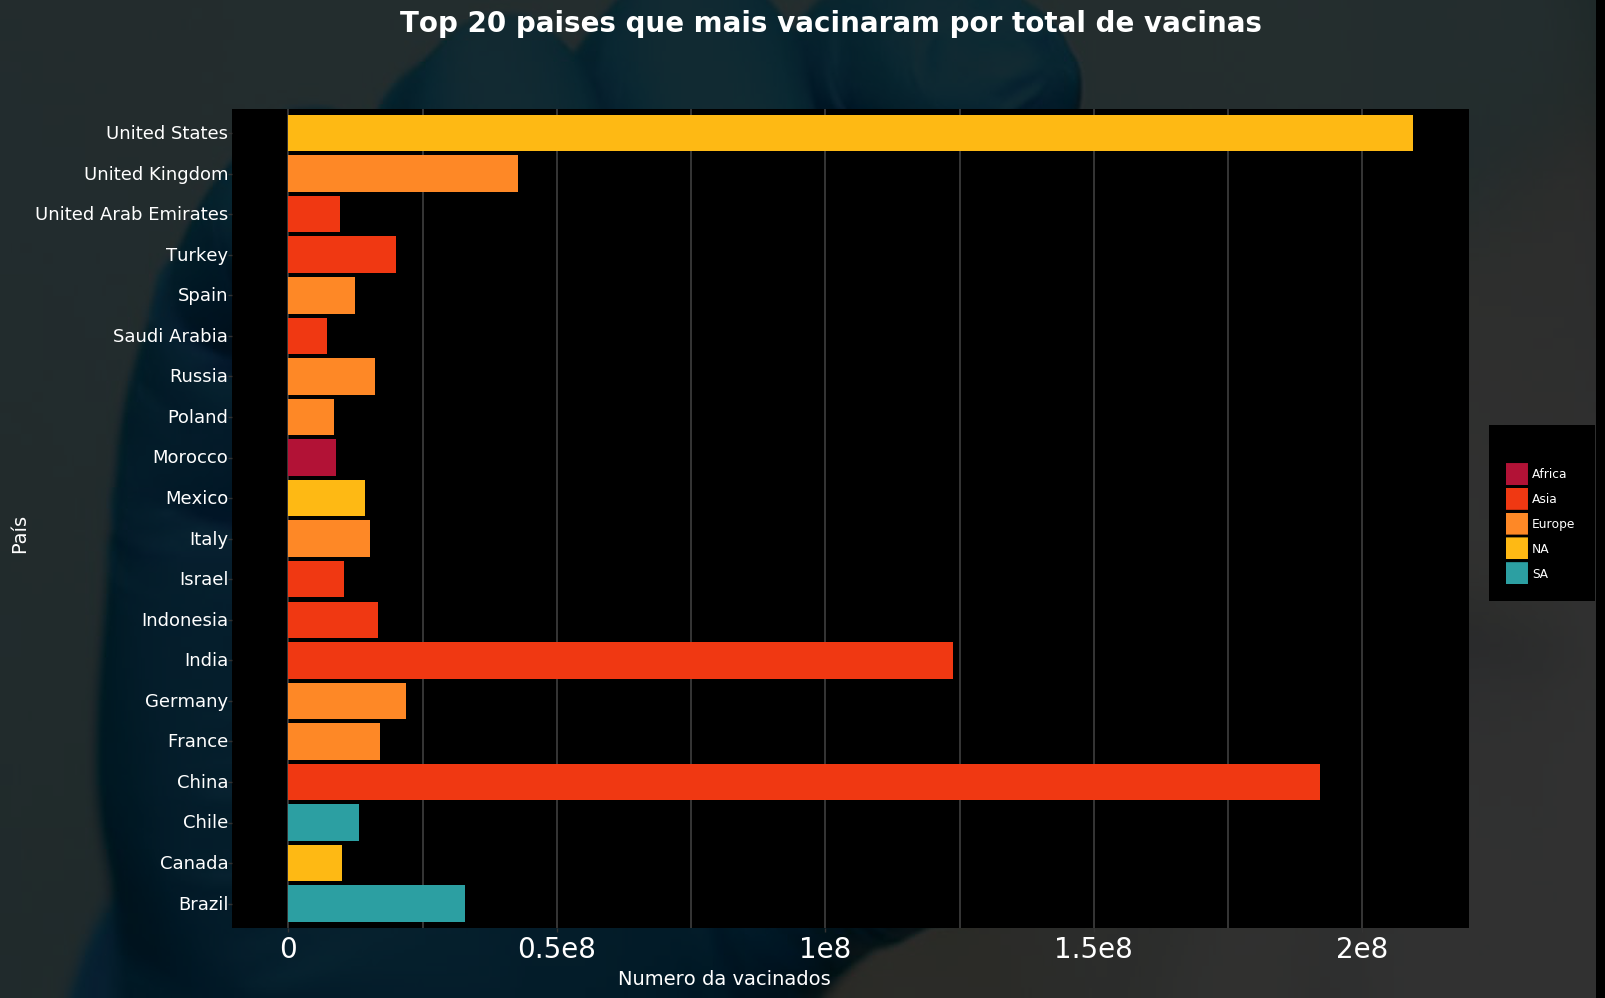

In [19]:
to20Paises = pd.DataFrame(vacinacao_data.groupby("country")["total_vaccinations"].max().sort_values(ascending = False).head(20))
to20Paises.reset_index(level=0,inplace=True)
to20Paises = convert_df_with_continent(to20Paises)
to20Paises['number_labels'] = ['']*to20Paises.shape[0]

for i in range(to20Paises.shape[0]):
    to20Paises['number_labels'].iloc[i] = format_number(to20Paises['total_vaccinations'].iloc[i])
    
op.figure_size=(8,5)
ax = (ggplot(to20Paises)         
 + aes(x='country', y='total_vaccinations',fill='continent')    
 + geom_col(size=20)
#  + geom_label(aes(label = 'number_labels'),ha='right',color = "white",label_padding= 0.25)
 + coord_flip()
 + scale_fill_manual(values = ["#B21236","#F03812","#FE8826","#FEB914","#2C9FA2","#002C2B","#F7E1C0"])
 + labs(title = "Top 20 paises que mais vacinaram por total de vacinas")
 + labs(y = "Numero da vacinados", x = "País")
 + theme(
    panel_background = element_rect(fill = "black"),    
    plot_background = element_rect(fill = "black", color = "black"),
    legend_background = element_rect(fill = "black"),
    legend_key = element_blank(),
   
    panel_grid = element_line(size = 0.3),
    panel_grid_minor_y = element_blank(),
    panel_grid_major_y = element_blank(),
    
    legend_text = element_text(color = "white"),
    axis_text_x = element_text(color = "white", size = 20),
    axis_text_y = element_text(color = "white", size = 13, hjust = 1, margin={'b': 20, 't':10}),
    axis_title = element_text(color = "white", size = 14, hjust = 1),
    plot_title = element_text(color = "white", face = "bold", size = 20, hjust = 4, margin={'b': 20, 't':10}),
    panel_spacing_x = 1
  )
)

fig = ax.draw()

image = plt.imread('https://raw.githubusercontent.com/vineethbabu/coronavaccine_images/main/1_enlargev3.png')

fig.figimage(image, xo=0, yo=0, alpha=0.2, norm=None, cmap=None, vmin=None, vmax=None, origin=None, resize=True)

fig.show()

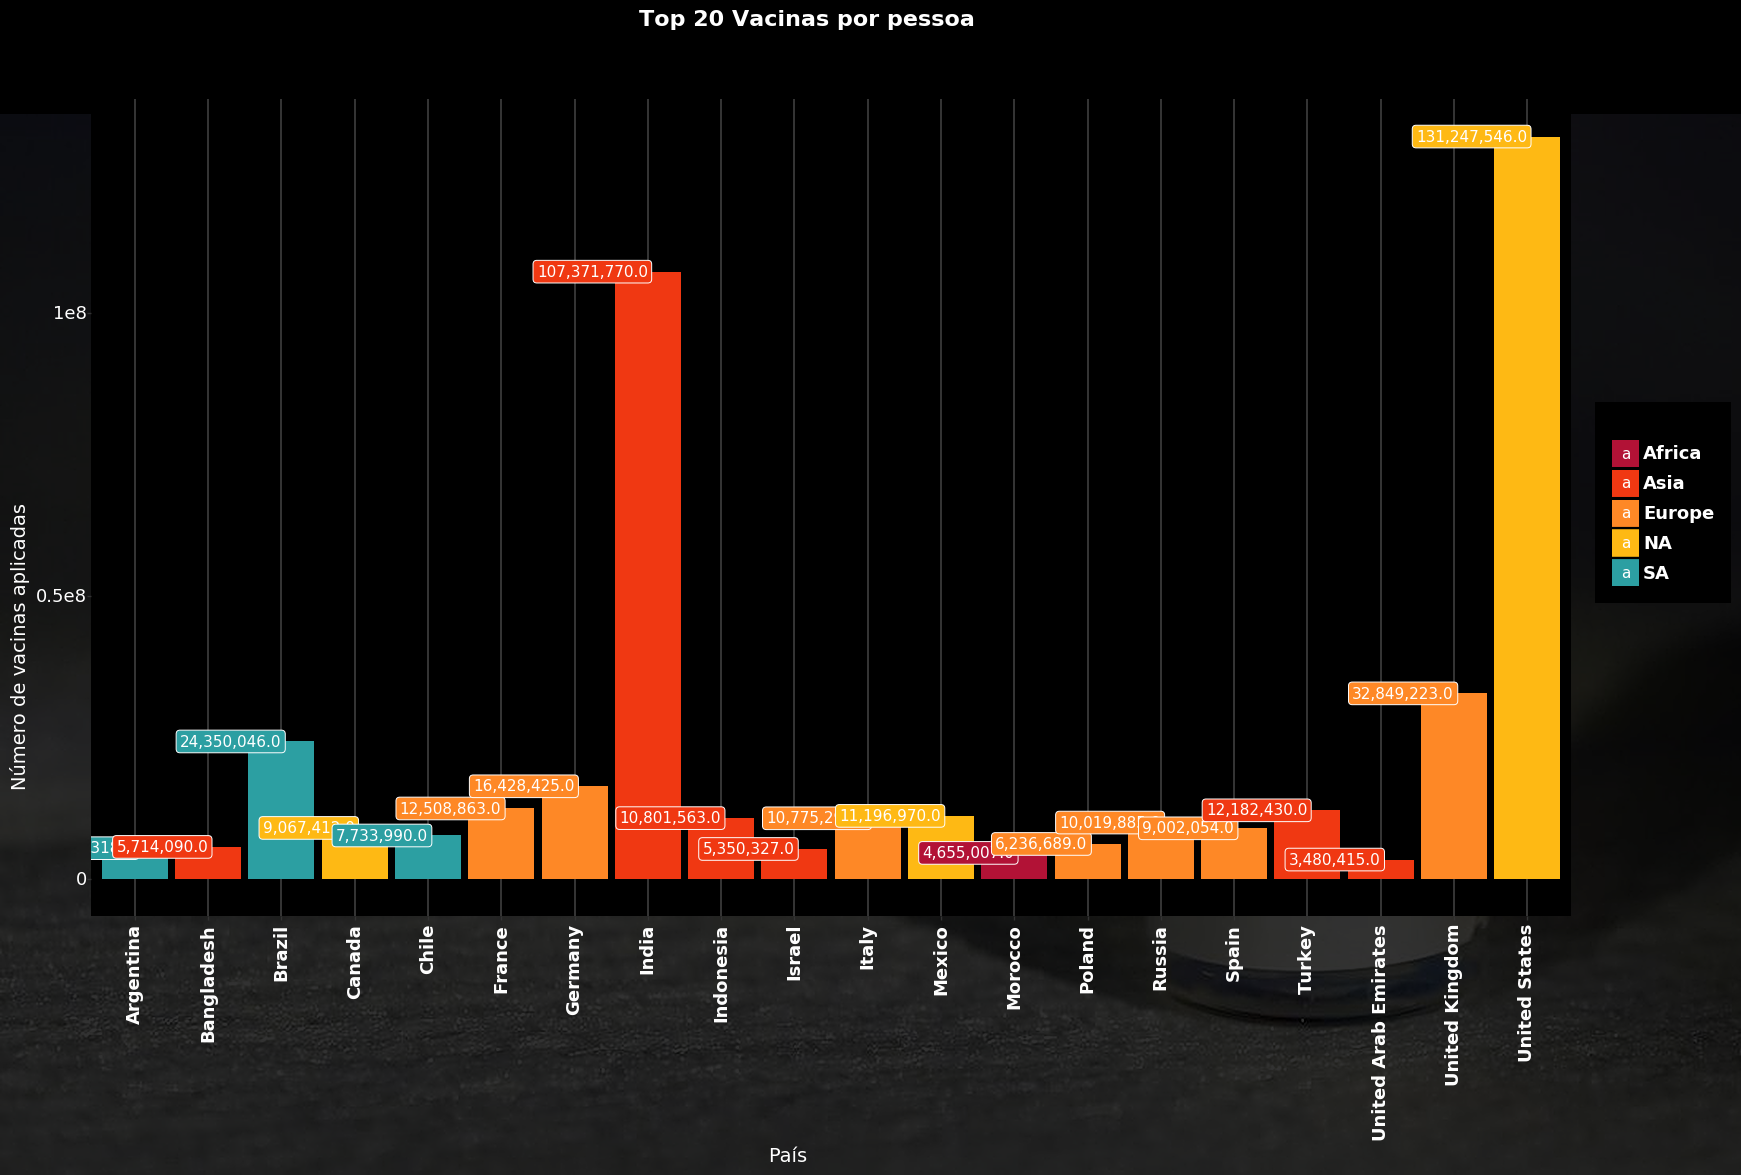

In [20]:
top_20_countries_people_vaccinated = pd.DataFrame(vacinacao_data.groupby("country")["people_vaccinated"].max().sort_values(ascending = False).head(20))
top_20_countries_people_vaccinated.reset_index(level=0,inplace=True)
top_20_countries_people_vaccinated = convert_df_with_continent(top_20_countries_people_vaccinated)
top_20_countries_people_vaccinated['number_labels'] = ['']*top_20_countries_people_vaccinated.shape[0]

for i in range(top_20_countries_people_vaccinated.shape[0]):
    top_20_countries_people_vaccinated['number_labels'].iloc[i] = format_number(top_20_countries_people_vaccinated['people_vaccinated'].iloc[i])
    
op.figure_size=(8,5)
ax = (ggplot(top_20_countries_people_vaccinated)         
 + aes(x='country', y='people_vaccinated',fill='continent')    
 + geom_col(size=15)
 + geom_label(aes(label = 'number_labels'),ha='right',color = "white",label_padding= 0.25,size=11)
 + scale_fill_manual(values = ["#B21236","#F03812","#FE8826","#FEB914","#2C9FA2","#002C2B","#F7E1C0"])
 + labs(title = "Top 20 Vacinas por pessoa")
 + labs(y = "Número de vacinas aplicadas", x = "País")
 + theme(
    panel_background = element_rect(fill = "black"),    
    plot_background = element_rect(fill = "black", color = "black"),
    legend_background = element_rect(fill = "black"),
    legend_key = element_blank(),
   
    panel_grid = element_line(size = 0.3),
    panel_grid_minor_y = element_blank(),
    panel_grid_major_y = element_blank(),
    
    legend_text = element_text(color = "white", size=13,face='bold'),
    axis_text_x = element_text(color = "white", size = 13,angle=90,face='bold'),
    axis_text_y = element_text(color = "white", size = 13, hjust = 1, margin={'b': 20, 't':10}),
    axis_title = element_text(color = "white", size = 14, hjust = 1),
    plot_title = element_text(color = "white", face = "bold", size = 16, hjust = 4, margin={'b': 20, 't':10}),
    panel_spacing_x = 1
  )
)

fig = ax.draw()

image = plt.imread('https://raw.githubusercontent.com/vineethbabu/coronavaccine_images/main/8_enlargev2.png')

fig.figimage(image, xo=0, yo=0, alpha=0.2, norm=None, cmap=None, vmin=None, vmax=None, origin=None, resize=True)

fig.show()

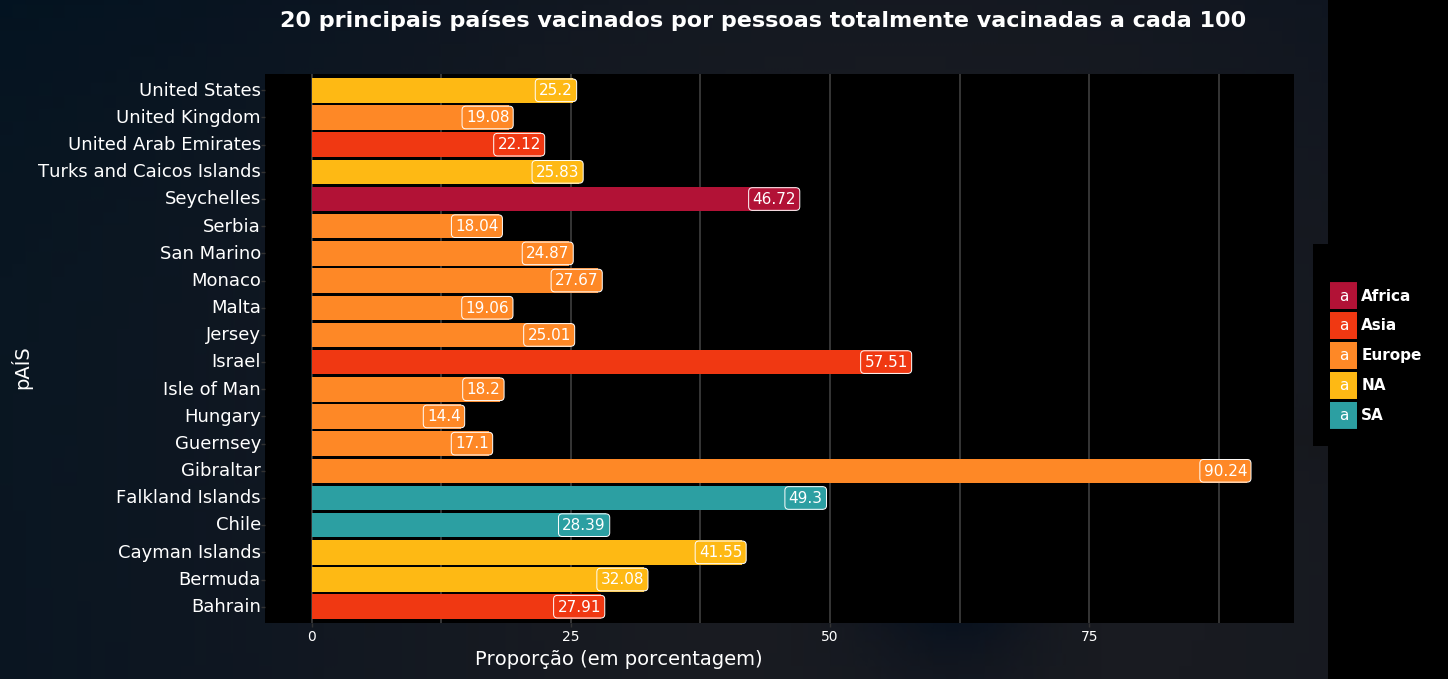

In [21]:
top_20_countries_pfvph = pd.DataFrame(vacinacao_data.groupby("country")["people_fully_vaccinated_per_hundred"].max().sort_values(ascending = False).head(20))
top_20_countries_pfvph.reset_index(level=0,inplace=True)
top_20_countries_pfvph = convert_df_with_continent(top_20_countries_pfvph)

top_20_countries_pfvph['number_labels'] = ['']*top_20_countries_pfvph.shape[0]

for i in range(top_20_countries_pfvph.shape[0]):
    top_20_countries_pfvph['number_labels'].iloc[i] = format_number(top_20_countries_pfvph['people_fully_vaccinated_per_hundred'].iloc[i])
op.figure_size=(7,5)
ax = (ggplot(top_20_countries_pfvph)         
 + aes(x='country', y='people_fully_vaccinated_per_hundred',fill='continent')    
 + geom_col(size=13)
 + geom_label(aes(label = 'number_labels'),ha='right',color = "white",label_padding= 0.25)
 + coord_flip()
 + scale_fill_manual(values = ["#B21236","#F03812","#FE8826","#FEB914","#2C9FA2","#002C2B","#F7E1C0"])
 + labs(title = "20 principais países vacinados por pessoas totalmente vacinadas a cada 100")
 + labs(y = "Proporção (em porcentagem)", x = "pAÍS")
 + theme(
    panel_background = element_rect(fill = "black"),    
    plot_background = element_rect(fill = "black", color = "black"),
    legend_background = element_rect(fill = "black"),
    legend_key = element_blank(),
   
    panel_grid = element_line(size = 0.3),
    panel_grid_minor_y = element_blank(),
    panel_grid_major_y = element_blank(),
    
    legend_text = element_text(color = "white",size=11,face='bold'),
    axis_text_x = element_text(color = "white", size = 10),
    axis_text_y = element_text(color = "white", size = 13, hjust = 1, margin={'b': 20, 't':10}),
    axis_title = element_text(color = "white", size = 14, hjust = 1),
    plot_title = element_text(color = "white", face = "bold", size = 16, hjust = 4, margin={'b': 20, 't':10}),
    panel_spacing_x = 1
  )
)

fig = ax.draw()

image = plt.imread('https://raw.githubusercontent.com/vineethbabu/coronavaccine_images/main/12.png')

fig.figimage(image, xo=0, yo=0, alpha=0.15, norm=None, cmap=None, vmin=None, vmax=None, origin=None, resize=True)

fig.show()

In [22]:
VacinasEmpresas = pd.read_csv('./data/covid/country_vaccinations_by_manufacturer.csv')

ContarVacinas = pd.DataFrame(VacinasEmpresas.groupby("vaccine")["total_vaccinations"].max().sort_values(ascending = False))
ContarVacinas.reset_index(level=0,inplace=True)

ContarVacinas['number_labels'] = ['']*ContarVacinas.shape[0]

for i in range(ContarVacinas.shape[0]):
    ContarVacinas['number_labels'].iloc[i] = format_number(ContarVacinas['total_vaccinations'].iloc[i])
    

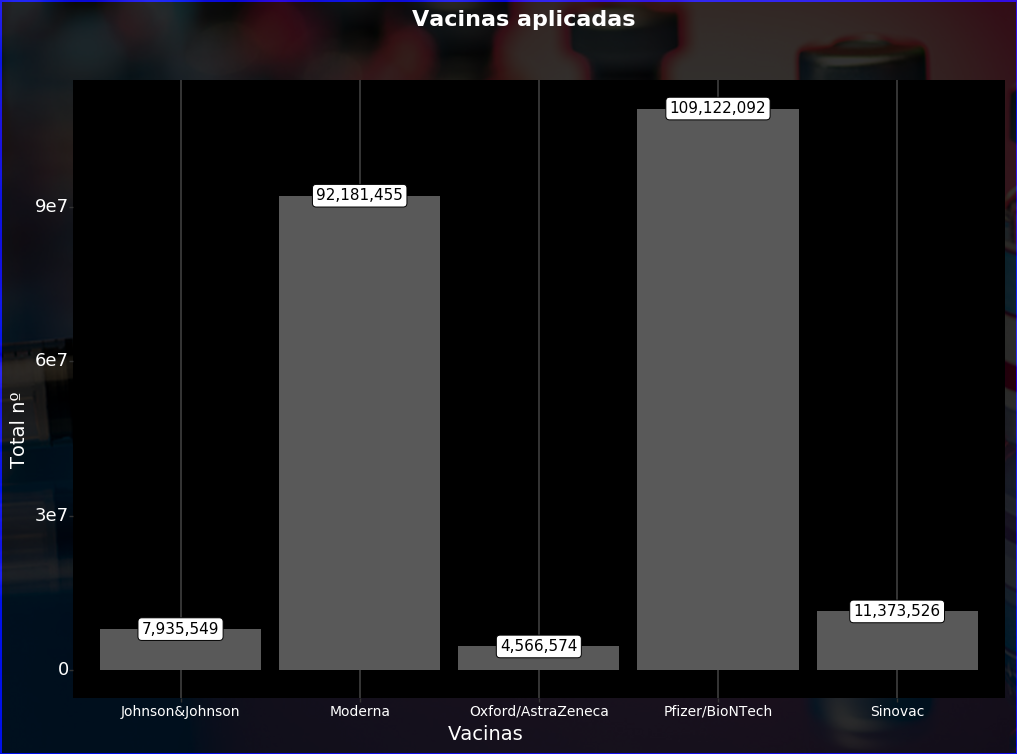

In [23]:
op.figure_size=(8,5)
ax = (ggplot(ContarVacinas)         
 + aes(x='vaccine', y='total_vaccinations')    
 + geom_col(size=15)
 + geom_label(aes(label = 'number_labels'),ha='center',color = "black",label_padding= 0.25)
 + scale_fill_manual(values = ["#B21236","#F03812","#FE8826","#FEB914","#2C9FA2","#002C2B","#F7E1C0"])
 + labs(title = "Vacinas aplicadas")
 + labs(y = "Total nº ", x = "Vacinas")
 + theme(
    panel_background = element_rect(fill = "black"),    
    plot_background = element_rect(fill = "black", color = "blue"),
    legend_background = element_rect(fill = "black"),
    legend_key = element_blank(),
   
    panel_grid = element_line(size = 0.3),
    panel_grid_minor_y = element_blank(),
    panel_grid_major_y = element_blank(),
    
    legend_text = element_text(color = "white"),
    axis_text_x = element_text(color = "white", size = 10),
    axis_text_y = element_text(color = "white", size = 13, hjust = 1, margin={'b': 20, 't':10}),
    axis_title = element_text(color = "white", size = 14, hjust = 1),
    plot_title = element_text(color = "white", face = "bold", size = 16, hjust = 4, margin={'b': 20, 't':10}),
    panel_spacing_x = 1
  )
)

fig = ax.draw()

image = plt.imread('https://raw.githubusercontent.com/vineethbabu/coronavaccine_images/main/4.png')

fig.figimage(image, xo=0, yo=0, alpha=0.2, norm=None, cmap=None, vmin=None, vmax=None, origin=None, resize=True)

fig.show()